# Cats and Dogs Classification using CNN
smaller subset of the original dataset is used to mimick the real world projects <br>
(as Francois Chollet states that often problems at hand will not have large data like this)

### Download the dataset
uncomment the following snippet

In [3]:
"""

%pip install kaggle

import os 
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.competition_download_files("dogs-vs-cats", path="./")

# unzip the dataset
with zipfile.ZipFile("./dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall("./cats_vs_dogs")

with zipfile.ZipFile("./cats_vs_dogs/train.zip", "r") as zip_ref:
    zip_ref.extractall("./cats_vs_dogs")

"""

'\n\n%pip install kaggle\n\nimport os \nimport zipfile\nfrom kaggle.api.kaggle_api_extended import KaggleApi\n\n# Initialize the kaggle API\napi = KaggleApi()\napi.authenticate()\n\n# Download the dataset\napi.competition_download_files("dogs-vs-cats", path="./")\n\n# unzip the dataset\nwith zipfile.ZipFile("./dogs-vs-cats.zip", \'r\') as zip_ref:\n    zip_ref.extractall("./cats_vs_dogs")\n\nwith zipfile.ZipFile("./cats_vs_dogs/train.zip", "r") as zip_ref:\n    zip_ref.extractall("./cats_vs_dogs")\n\n'

### Split into training, validation and test data
Sample data: train/cat/1.jpg


In [4]:
import shutil, pathlib
import os 

original_dir = pathlib.Path("cats_vs_dogs/train")
new_base_dir = pathlib.Path("cat_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" 
                  for i in range(start_index, end_index)] 
        for fname in fnames:
            shutil.copyfile(
                src=original_dir / fname,
                dst=dir / fname)
            
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Create dataset objects from the images

In [5]:
import pathlib
new_base_dir = pathlib.Path("cat_vs_dogs_small")

# JPG -> tensor
from keras.utils import image_dataset_from_directory


train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


2024-07-09 18:20:44.160444: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 18:20:44.167492: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 18:20:44.228923: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 18:20:44.298856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 18:20:44.378953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### A convolutional model using Keras Functional API

Model Definition

In [6]:
import keras
from keras import layers


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [8]:
# Fitting the classifier using a Dataset
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30


63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 678ms/step - accuracy: 0.5244 - loss: 0.7035 - val_accuracy: 0.5380 - val_loss: 0.6911
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 716ms/step - accuracy: 0.5314 - loss: 0.6936 - val_accuracy: 0.5070 - val_loss: 0.6891
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - accuracy: 0.5627 - loss: 0.6899 - val_accuracy: 0.6350 - val_loss: 0.6558
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.5724 - loss: 0.6894 - val_accuracy: 0.6440 - val_loss: 0.6412
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 734ms/step - accuracy: 0.6239 - loss: 0.6422 - val_accuracy: 0.6590 - val_loss: 0.6126
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.6711 - loss: 0.6070 - val_accuracy: 0.6950 - val_loss: 0.5881
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 724ms/step - accuracy: 0.7238 - loss: 0.5597 - val_accuracy: 0.6970 - val_loss: 0.6020
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 753ms/step - accuracy: 0.7468 - loss: 0.5163 - val_accuracy: 0.691

Performance

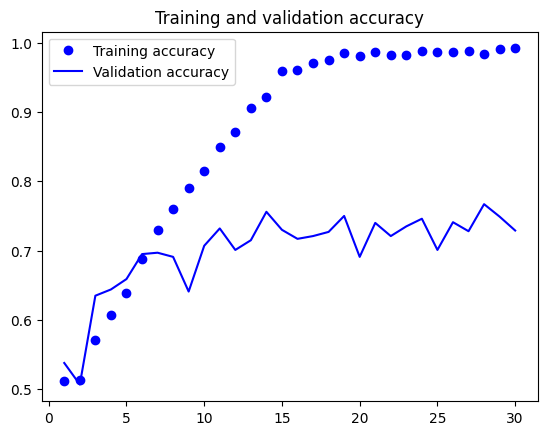

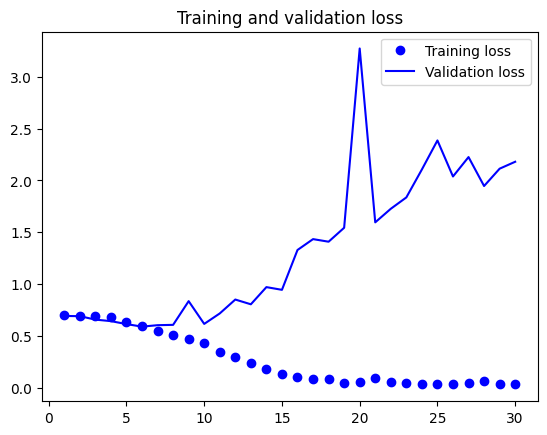

In [9]:
# Plotting the performance metrics
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show() 

In [10]:
# Model evaluation on test data
test_model = keras.models.load_model("convnet_from_scratch.keras") # load the best model
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.6763 - loss: 0.5947
Test accuracy: 0.690


### Fighting Overfitting using Data Augmentation
<p style="display:none">(I always feared it to be done by datageneretor)</p>


In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1), # random rotation by 0.1 * (2pi)
    layers.RandomZoom(0.2),     # random zoom in or zoom out by a scale factor in the range [-.2, .2]
])

2024-07-09 18:40:24.491008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


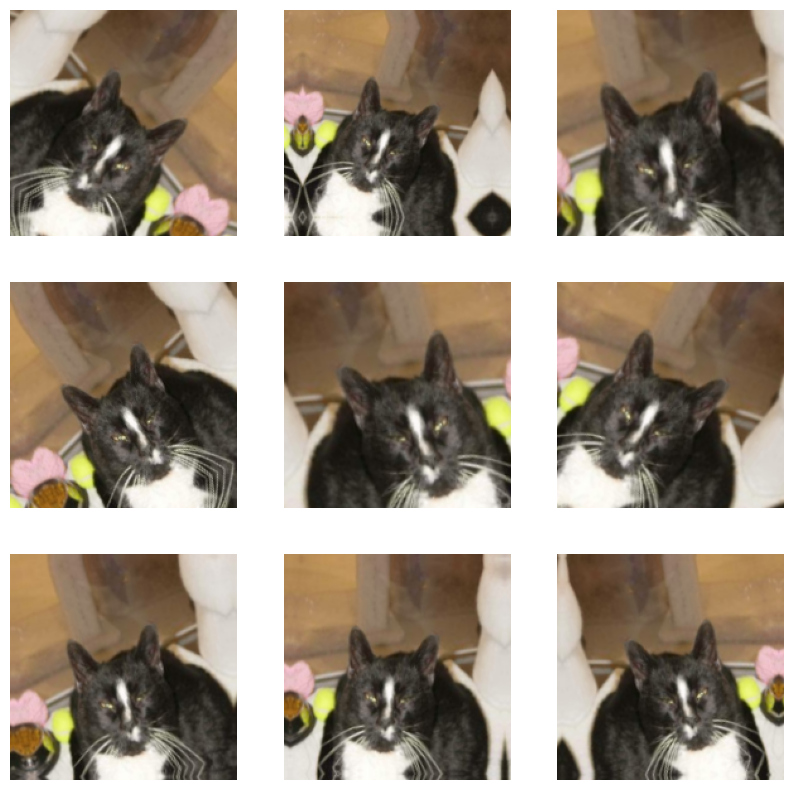

In [12]:
# Displaying some randomly augmented training images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): # random one batch
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
# New Convnet with augmentation and dropout
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [14]:
# Training the regularized convnet
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 609ms/step - accuracy: 0.5037 - loss: 0.8173 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 605ms/step - accuracy: 0.5281 - loss: 0.6929 - val_accuracy: 0.5170 - val_loss: 0.6948
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.5809 - loss: 0.6835 - val_accuracy: 0.5760 - val_loss: 0.6619
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 582ms/step - accuracy: 0.6264 - loss: 0.6553 - val_accuracy: 0.6300 - val_loss: 0.6378
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 585ms/step - accuracy: 0.6372 - loss: 0.6393 - val_accuracy: 0.6690 - val_loss: 0.6034
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.6598 - loss: 0.6197 - val_accuracy: 0.6680 - val_loss: 0.5810
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.6682 - loss: 0.5952 - val_accuracy: 0.6140 - val_loss: 0.6925
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 583ms/step - accuracy: 0.6979 - loss: 0.5907 - 

KeyboardInterrupt: 

In [15]:
# Evaluation on the test set
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.7781 - loss: 0.4754
Test accuracy: 0.780


## Using Pretrained Models

### Pretrained Model with no augmentation layer

#### Bottom Layers
We will be using VGG16 bottom layers as convolutional base for our model

In [16]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fast feature extraction without augmentation
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

2024-07-09 19:09:05.810728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

2024-07-09 19:10:34.393651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

2024-07-09 19:14:04.843746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
test_features.shape

(2000, 5, 5, 512)

#### Top Layers

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=[val_features, val_labels],
    callbacks=callbacks
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8554 - loss: 48.5594 - val_accuracy: 0.9630 - val_loss: 4.8498
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9771 - loss: 3.9269 - val_accuracy: 0.9710 - val_loss: 5.6014
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9892 - loss: 1.2141 - val_accuracy: 0.9740 - val_loss: 3.9363
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9906 - loss: 1.2332 - val_accuracy: 0.9790 - val_loss: 3.4301
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9922 - loss: 0.6366 - val_accuracy: 0.9680 - val_loss: 5.6983
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9965 - loss: 0.6526 - val_accuracy: 0.9720 - val_loss: 4.8911
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9970 - loss: 0.1605 - val_accuracy: 0.9720 - val_loss: 4.0052
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9957 - loss: 0.4344 - val_accuracy: 0.9660 - 

Plotting the results

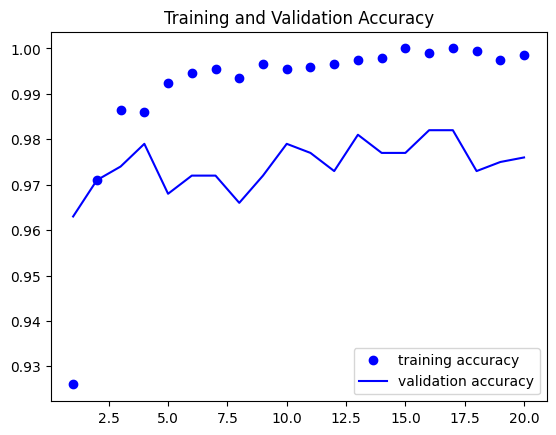

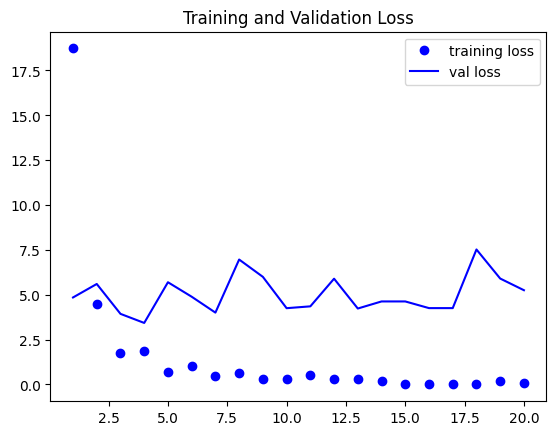

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="training accuracy")
plt.plot(epochs, val_acc, "b", label="validation accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="val loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### Pretrained Models using augmentation

In [18]:
# Instatiating and freezing the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)
conv_base.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Note: after changing weight trainability, it is nessecary to recomile the model

In [ ]:
# Training
# I will not run the next parts as it is computationaly expensive (and I don't have a GPU setup)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

# Test accuracy
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

#### Fine-Tunning the VGG16 (some layers from the base)

In [19]:
# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
# Comile and train the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # delibarately lr made small to avoid harming the previous representations learned by the model
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tunning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

In [ ]:
# Evaluate on test data
model = keras.models.load_model("fine_tunning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")